# Data Collection

In [ ]:
import requests
import pandas as pd

In [ ]:

def get_exchange_rates(start_date, end_date, base_currency, target_currency):
    url = "https://api.apilayer.com/exchangerates_data/timeseries"
    headers = {
        "apikey": "BUzl4p9lp3wg7cFEgfJrep8veqpZMxJO"
    }
    rates = {}
    year = pd.Timedelta(days=365)
    query_date = pd.to_datetime(end_date)
    while query_date >= pd.to_datetime(start_date):
        # Set the start and end dates for the current year
        current_year_start = (query_date - year).strftime('%Y-%m-%d')
        current_year_end = query_date.strftime('%Y-%m-%d')
        params = {'access_key': 'BUzl4p9lp3wg7cFEgfJrep8veqpZMxJO',
                  'start_date': current_year_start,
                  'end_date': current_year_end,
                  'base': base_currency,
                  'symbols': target_currency}
        try:
            response = requests.get(url, params=params, headers=headers)
            response.raise_for_status()
            data = response.json()
            rates.update(data['rates'])
        except requests.exceptions.RequestException as e:
            print("Error: ", e)
        query_date -= year
    # Create a DataFrame from the rates dictionary
    df = pd.DataFrame.from_dict(rates, orient='index')
    return df

df_CNY = get_exchange_rates('2013-12-31','2022-12-31','CNY','USD')
df_CAD = get_exchange_rates('2013-12-31','2022-12-31','CAD','USD')
df_EUR = get_exchange_rates('2013-12-31','2022-12-31','EUR','USD')
df_GBP = get_exchange_rates('2013-12-31','2022-12-31','CNY','USD')
df_JPY = get_exchange_rates('2013-12-31','2022-12-31','JPY','USD')
df_KRW = get_exchange_rates('2013-12-31','2022-12-31','KRW','USD')
df_INR = get_exchange_rates('2013-12-31','2022-12-31','INR','USD')
df_RUB = get_exchange_rates('2013-12-31','2022-12-31','RUB','USD')

# Data cleaning + preprocessing

### Inflation rate

In [ ]:
df= pd.read_csv('DP_LIVE_05032023170628727.csv')

In [ ]:
# Convert the 'Time' column to datetime format
df['TIME'] = pd.to_datetime(df['TIME'])

# Select rows with 'CHN', 'FRA', 'CAN', 'JPN', 'KOR', 'GBR', 'USA', 'IND', 'RUS', 'DEU' country codes and a timestamp between 2013 and 2022
mask = (df['LOCATION'].isin(['CHN','FRA','CAN','JPN','KOR','GBR','USA','IND','RUS','DEU','ITA'])) & (df['TIME'].dt.year >= 2013) & (df['TIME'].dt.year <= 2022)
CPI_data = df.loc[mask]

CPI_data=CPI_data.drop(['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes'],axis=1)

In [ ]:
CPI_data.to_excel('CPI_data.xlsx', index=False)

### Monthly average exchange rate

In [ ]:
def monthly_average(df):
    df.index = pd.to_datetime(df.index)
    monthly_average = df.resample('M').mean()
    monthly_average = monthly_average.reset_index(drop=False)
    return monthly_average

monthly_average_CAD=monthly_average(df_CAD)
monthly_average_CNY=monthly_average(df_CNY)
monthly_average_EUR=monthly_average(df_EUR)
monthly_average_GBP=monthly_average(df_GBP)
monthly_average_JPY=monthly_average(df_JPY)
monthly_average_INR=monthly_average(df_INR)
monthly_average_KRW=monthly_average(df_KRW)
monthly_average_RUB=monthly_average(df_RUB)

### Conact Dataframe

In [19]:
df1=pd.read_excel('CPI_data.xlsx')

In [20]:

def country_data(df, country_code, exchange_rate_df):
    # Filter the data frame to only include rows with the specified country code
    mask = df['LOCATION'] == country_code
    country_data = df.loc[mask].reset_index(drop=True)
    
    exchange_rate_df = exchange_rate_df.reset_index(drop=True)
    
    country_data = pd.concat([country_data, exchange_rate_df], axis=1)
    
    return country_data


In [ ]:
df_CHN=country_data(df1,'CHN',monthly_average_CNY)
df_CAN=country_data(df1,'CAN',monthly_average_CAD)
df_FRA=country_data(df1,'FRA',monthly_average_EUR)
df_ITA=country_data(df1,'ITA',monthly_average_EUR)
df_DEU=country_data(df1,'DEU',monthly_average_EUR)
df_GBR=country_data(df1,'GBR',monthly_average_GBP)
df_IND=country_data(df1,'IND',monthly_average_INR)
df_JPN=country_data(df1,'JPN',monthly_average_JPY)
df_RUS=country_data(df1,'RUS',monthly_average_RUB)
df_KOR=country_data(df1,'KOR',monthly_average_KRW)

# US as the reference
mask = df1['LOCATION'] == 'USA'
df_USA= df1.loc[mask]
df_USA

### Reshaping by year series

In [ ]:

# Create an empty dictionary to store the new dataframes
yearly_dfs = {}

df_list = [df_CHN, df_USA, df_FRA, df_DEU, df_ITA, df_IND, df_RUS, df_GBR, df_CAN, df_KOR, df_JPN]

for df in df_list:
    df.loc[:, 'TIME'] = pd.to_datetime(df.loc[:, 'TIME'])

# Loop through each year from 2013 to 2022
for year in range(2013, 2023):
    # Create a list to store the dataframes for the current year
    dfs_for_year = []
    # Loop through each original dataframe
    for df_name in ['df_CHN', 'df_FRA', 'df_DEU', 'df_ITA', 'df_IND', 'df_RUS', 'df_GBR', 'df_CAN', 'df_KOR','df_JPN']:
        # Extract the year from the TIME column and select only the rows for the current year
        df_for_year = globals()[df_name][globals()[df_name]['TIME'].dt.year == year]
        # Append the dataframe to the list
        dfs_for_year.append(df_for_year)
    # Concatenate all the dataframes for the current year into a single dataframe
    yearly_dfs[str(year)] = pd.concat(dfs_for_year, ignore_index=True)

# Access the new dataframes using their year as a key
df_2013=yearly_dfs['2013']  # dataframe for 2013
df_2014=yearly_dfs['2014']
df_2015=yearly_dfs['2015']
df_2016=yearly_dfs['2016']
df_2017=yearly_dfs['2017']
df_2018=yearly_dfs['2018']
df_2019=yearly_dfs['2019']
df_2020=yearly_dfs['2020']
df_2021=yearly_dfs['2021']
df_2022=yearly_dfs['2022']

merged_df = pd.concat(yearly_dfs.values())

# Visualization

### MAP

In [9]:
import plotly.express as px

In [10]:
mask = (df1['TIME'].dt.year == 2022)
df_CPI = df1.loc[mask]
df_CPI = df_CPI.groupby('LOCATION').mean()
#df_CPI = df_CPI.resample('Y', on='TIME').mean()
# change the index to 'Country'
df_CPI = df_CPI.reset_index()
df_CPI = df_CPI.rename(columns={'LOCATION':'Country', 'Value':'CPI'})
# change the country name to full name
df_CPI['Country'] = df_CPI['Country'].replace(['CHN', 'GBR', 'USA','CAN','DEU','FRA','IND','ITA','JPN','KOR','RUS'], ['China', 'United Kingdom', 'United States','Canada','Germany','France','India','Italy','Japan','Korea','Russia'])
df_CPI

/var/folders/7t/q4xs_2kn20v_3868fkmt4bg00000gn/T/ipykernel_24010/1292429545.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_CPI = df_CPI.groupby('LOCATION').mean()


,Country,CPI
0,Canada,6.798090
1,China,1.958333
2,Germany,7.884740
3,France,5.215159
4,United Kingdom,7.900000
5,India,5.900609
6,Italy,8.179537
7,Japan,2.508333
8,Korea,5.084463
9,Russia,11.531454


In [11]:
# Create a choropleth map with the CPI values
fig = px.choropleth(df_CPI, locations='Country', locationmode='country names',
                    color='CPI', range_color=(0, 10),
                    title='2022 Average Consumer Price Index(CPI) by Country')

# Show the map
fig.show()

### Line chart

Overall trend

In [8]:
from plotnine import *

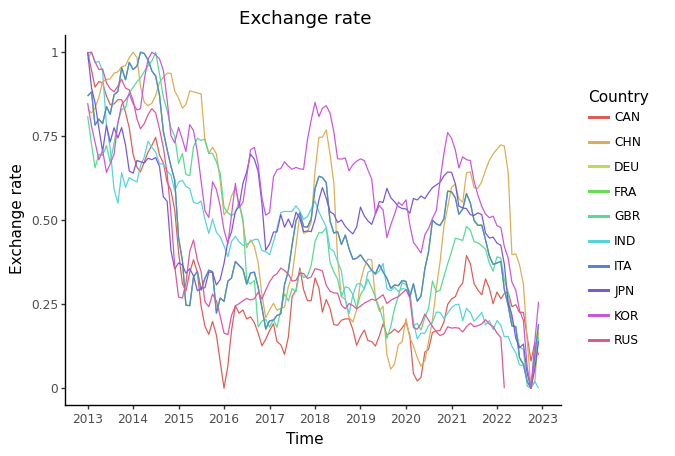

<ggplot: (8785146828843)>

In [39]:
p1 = ggplot(merged_df, aes(x='TIME', y='Exchange Rate', color='LOCATION')) + geom_line() + labs(title='Exchange rate', x='Time', y='Exchange rate') + scale_color_discrete(name='Country') + theme_classic() +  scale_x_datetime(date_labels='%Y')
p1

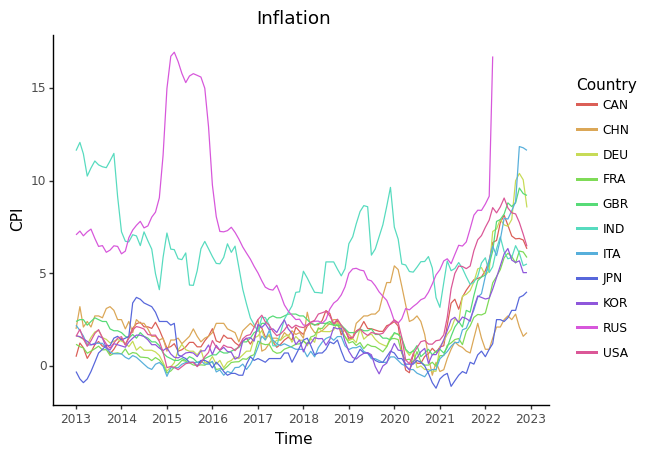

<ggplot: (8785116963792)>

In [34]:

p2 = ggplot(df1, aes(x='TIME', y='Value', color='LOCATION')) + geom_line() + labs(title='Inflation', x='Time', y='CPI') + scale_color_discrete(name='Country') + theme_classic() +  scale_x_datetime(date_labels='%Y')

p2

### Country trend

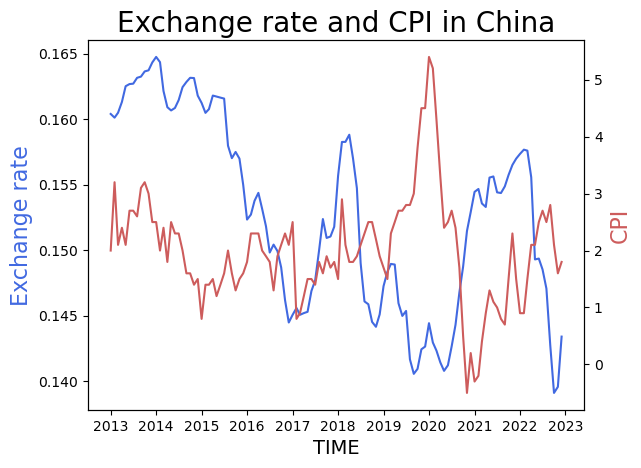

In [8]:
import matplotlib.pyplot as plt

def plot_exchange_rate(df,coloumn, title):
    fig,ax=plt.subplots()
    ax.plot(df.TIME, df[coloumn], color='#4169E1')
    ax.set_xlabel('TIME',fontsize=14)
    ax.set_ylabel('Exchange rate', color='#4169E1', fontsize=16)
    ax2=ax.twinx()
    ax2.plot(df.TIME, df.Value, color='#CD5C5C')
    ax2.set_ylabel('CPI', color='#CD5C5C', fontsize=16)
    plt.title(title, fontsize=20)
    plt.show()


plot_exchange_rate(df_CHN,'Exchange rate and CPI in China')
plot_exchange_rate(df_CAN,'Exchange rate and CPI in Canada')
plot_exchange_rate(df_FRA,'Exchange rate and CPI in France')
plot_exchange_rate(df_ITA,'Exchange rate and CPI in Italy')
plot_exchange_rate(df_DEU,'Exchange rate and CPI in Germany')
plot_exchange_rate(df_GBR,'Exchange rate and CPI in UK')
plot_exchange_rate(df_IND,'Exchange rate and CPI in India')
plot_exchange_rate(df_JPN,'Exchange rate and CPI in Japan')
plot_exchange_rate(df_RUS,'Exchange rate and CPI in Russia')
plot_exchange_rate(df_KOR,'Exchange rate and CPI in South Korea')